In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/data-20220529T174704Z-001.zip

Archive:  /content/drive/MyDrive/data-20220529T174704Z-001.zip
  inflating: data/README.txt         
  inflating: data/tnbc/.DS_Store     
  inflating: data/tnbc/Images/.DS_Store  
  inflating: data/cpm15/Images/image_06.png  
  inflating: data/cpm15/Images/image_03.png  
  inflating: data/cpm15/Images/image_07.png  
  inflating: data/cpm15/Images/image_10.png  
  inflating: data/kumar/train/Overlay/TCGA-18-5592-01Z-00-DX1.png  
  inflating: data/kumar/train/Overlay/TCGA-G9-6336-01Z-00-DX1.png  
  inflating: data/kumar/train/Overlay/TCGA-AR-A1AS-01Z-00-DX1.png  
  inflating: data/cpm15/Images/image_09.png  
  inflating: data/kumar/train/Overlay/TCGA-A7-A13F-01Z-00-DX1.png  
  inflating: data/cpm15/Images/image_14.png  
  inflating: data/cpm15/Images/image_13.png  
  inflating: data/cpm15/Images/image_02.png  
  inflating: data/cpm15/Images/image_01.png  
  inflating: data/cpm15/Images/image_00.png  
  inflating: data/kumar/train/Overlay/TCGA-50-5931-01Z-00-DX1.png  
  inflating: data/c

In [1]:
train_path = "/content/data/cpm17/train"
test_path = "/content/data/cpm17/test"

In [2]:
import glob
from skimage import io
import scipy.io as sio
from skimage import data, io, util
from matplotlib import pyplot as plt
import numpy as np

import cv2
import os
import shutil
import random


In [3]:
def random_colour_masks(image):
    """
    random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, threshold):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0

    """
    #img = Image.open(img_path)
    #transform = T.Compose([T.ToTensor()])
    #img = get_transform(train=False)
    #pred = model([img])
    img, apred = dataset_test[0]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
     pred = model([img.to(device)])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1] #considering boxes having only 0.5% accuracy
    pred_t= len(pred_score)
    masks = ((pred[0]['masks'].mul(255))>0.5).squeeze().detach().cpu().numpy()
    pred_class = ["Nucleus" for i in list(pred[0]['labels'].detach().cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return img,masks,pred_boxes,pred_class
    """
    label = apred['labels'].numpy()
    pred_boxes = apred['boxes'].numpy()
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(apred['boxes'].numpy())]

    #pred_boxes = pred_boxes[:len(label)+1]

    return img,apred['masks'].numpy(), pred_boxes, apred['labels'].numpy()
    """


def instance_segmentation_api(img_path, threshold=0.5, rect_th=1, text_size=3, text_th=3):
    """
    instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
    """
    img,masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    
    #img = cv2.imread(img_path)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    print(len(masks))
    print(len(boxes))
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])

        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        #cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

In [4]:
def read_annotation(annotPath):
    mask = sio.loadmat(annotPath)
    inst_map = mask['inst_map']
    return  inst_map

In [7]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 155343, done.
remote: Counting objects: 100% (7716/7716), done.
remote: Compressing objects: 100% (667/667), done.
remote: Total 155343 (delta 7100), reused 7571 (delta 7017), pack-reused 147627
Receiving objects: 100% (155343/155343), 304.88 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (137693/137693), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [5]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection.faster_rcnn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection import MaskRCNN
import math
from tqdm import tqdm

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [6]:
class cmp17Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Labels", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
      
        mask = read_annotation(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if(((xmin==xmax)or (ymin==ymax))):
              print("here")
              print(xmin)
              boxes.append([0.5*xmin,0.5* ymin, xmax,ymax])
            else:
               boxes.append([xmin,ymin,xmax,ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280

    #create an anchor_generator for the FPN which by default has 5 outputs
    anchor_generator = AnchorGenerator(
    sizes=((8,16,32,64,128),),
    aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)


    model = MaskRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   mask_roi_pool=mask_roi_pooler)
    return model


def get_transform(train):
    transform = []
    transform.append(T.ToTensor())
    if train:
        transform.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transform)



In [18]:

def train(model, optimizer, data_loader, device, n_epochs, print_freq):
    # Perform training loop for n epochs
  loss_list = []
  model.train()
  for epoch in tqdm(range(n_epochs)):
      loss_epoch = []
      iteration=1
      for images,targets in tqdm(data_loader):

          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          optimizer.zero_grad()
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          losses.backward()       
          optimizer.step()
          loss_epoch.append(losses.item())
          
          # Plot loss every 10th iteration
          iteration+=1
      loss_epoch_mean = np.mean(loss_epoch) 
      loss_list.append(loss_epoch_mean) 
      # loss_list.append(loss_epoch_mean)    
      print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))
  plt.plot(list(range(epoch+1)), loss_list)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

 
  # Save model
 # model_nr = latest_model() + 1 # keep track of which model nr was just trained. 
  #save_path = 'PUT YOUR SAVE PATH HERE'+str(model_nr)
  torch.save(model.state_dict(), '/content/drive/MyDrive/MobileNetCMP17.pt')
  return loss_list


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  7%|▋         | 1/15 [00:09<02:15,  9.67s/it]

Average loss for epoch = 3.6961 



 13%|█▎        | 2/15 [00:19<02:05,  9.67s/it]

Average loss for epoch = 2.1284 



 20%|██        | 3/15 [00:28<01:54,  9.50s/it]

Average loss for epoch = 2.0757 



 27%|██▋       | 4/15 [00:38<01:45,  9.55s/it]

Average loss for epoch = 2.0658 



 33%|███▎      | 5/15 [00:47<01:35,  9.55s/it]

Average loss for epoch = 2.0733 



 40%|████      | 6/15 [00:57<01:25,  9.51s/it]

Average loss for epoch = 2.0668 



 47%|████▋     | 7/15 [01:07<01:16,  9.61s/it]

Average loss for epoch = 2.0758 



 53%|█████▎    | 8/15 [01:17<01:08,  9.73s/it]

Average loss for epoch = 2.0931 



 60%|██████    | 9/15 [01:26<00:57,  9.56s/it]

Average loss for epoch = 2.0690 



 67%|██████▋   | 10/15 [01:35<00:47,  9.49s/it]

Average loss for epoch = 2.0548 



 73%|███████▎  | 11/15 [01:44<00:37,  9.44s/it]

Average loss for epoch = 2.0588 



 80%|████████  | 12/15 [01:54<00:28,  9.40s/it]

Average loss for epoch = 2.0349 



 87%|████████▋ | 13/15 [02:03<00:18,  9.39s/it]

Average loss for epoch = 2.0054 



 93%|█████████▎| 14/15 [02:13<00:09,  9.54s/it]

Average loss for epoch = 2.0140 



100%|██████████| 15/15 [02:23<00:00,  9.55s/it]


Average loss for epoch = 2.0106 


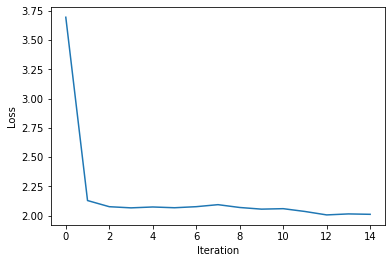

In [19]:

    # train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # our dataset has two classes only - background and person
num_classes = 2
    # use our dataset and defined transformations
dataset = cmp17Dataset(train_path, get_transform(train=True))
dataset_test = cmp17Dataset(test_path, get_transform(train=False))

    
    # define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
model = get_model_instance_segmentation(num_classes)

    # move model to the right device
model.to(device)

    # construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
 
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
 # let's train it for 10 epochs
num_epochs = 15
loss_list=train(model, optimizer, data_loader, device, num_epochs, print_freq=15)




In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(2)

    # move model to the right device
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/MobileNetCMP17.pt'))


<All keys matched successfully>

In [9]:

dataset_test = cmp17Dataset(test_path, get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=32, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
maskpre=[]
target=[]
for images, targets in tqdm(data_loader_test):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    target.append(targets[0]['masks'].cpu().detach().numpy())
    model.eval()
    with torch.no_grad():
      output = model(images)
      maskpre.append(output[0]['masks'].cpu().detach().numpy())




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1 [00:00<?, ?it/s]

here
208


100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


In [10]:
def IoU(y_real, y_pred):
  # Intersection over Union loss function
  intersection = y_real*y_pred
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.sum(intersection)/np.sum(union)

def dice_coef(y_real, y_pred, smooth=0):
      return 2. * (y_real*y_pred).sum() / (y_real+y_pred).sum()


In [11]:
IoU_scores_list=[]
dice_coef_scores_list=[]
for i in range(len(targets)):
  target_im = targets[i]['masks'][0].cpu().detach().numpy()
  for k in range(len(targets[i]['masks'])):
        target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
        target_im2[target_im2>0.5] = 1
        target_im2[target_im2<0.5] = 0
        target_im = target_im+target_im2
  target_im[target_im>0.5] = 1
  target_im[target_im<0.5] = 0
  target_im = target_im.astype('int64')
  
  output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
  for k in range(len(output[i]['masks'])):
    output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
    output_im2[output_im2>0.5] = 1
    output_im2[output_im2<0.5] = 0
    output_im = output_im+output_im2

  output_im[output_im>0.5] = 1
  output_im[output_im<0.5] = 0
  output_im = output_im.astype('int64')
  print(output_im)
  IoU_score = IoU(y_real=target_im, y_pred=output_im) 
  IoU_scores_list.append(IoU_score)
  dice_coef_score = dice_coef(y_real=target_im, y_pred=output_im)
  dice_coef_scores_list.append(dice_coef_score)
print('mean IoU score for test set:', np.mean(IoU_scores_list))
print('mean Dice Coefficient score for test set:', np.mean(dice_coef_scores_list))
 


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

In [14]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        
    plt.show()


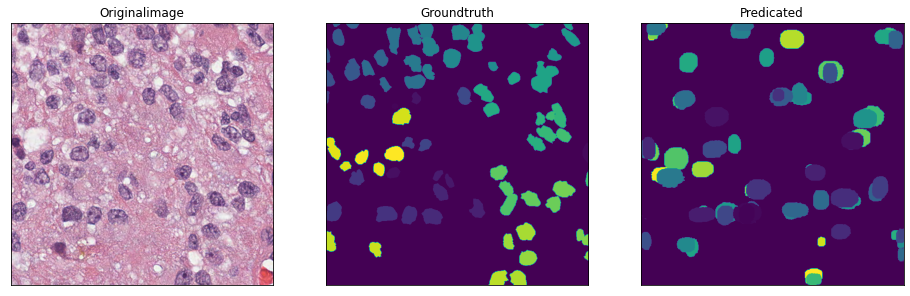

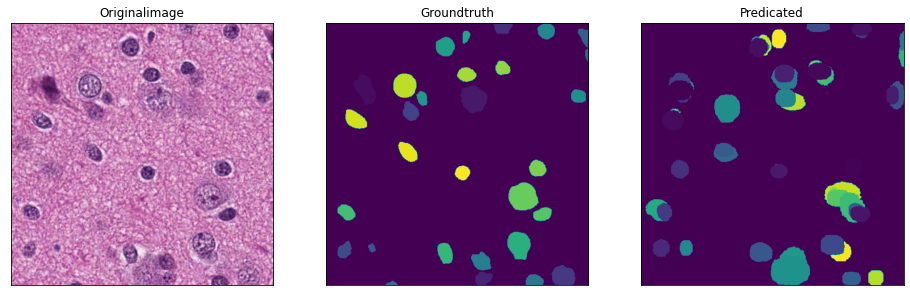

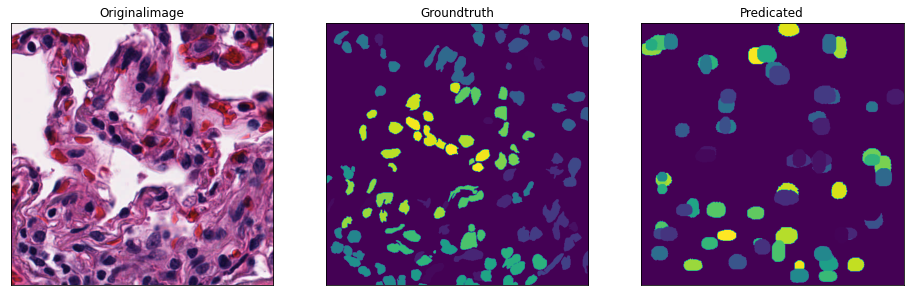

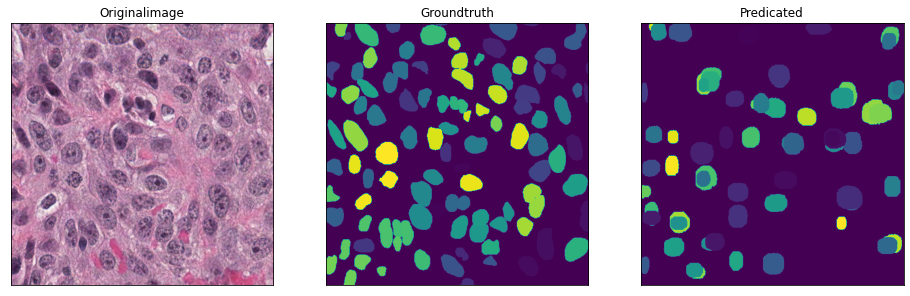

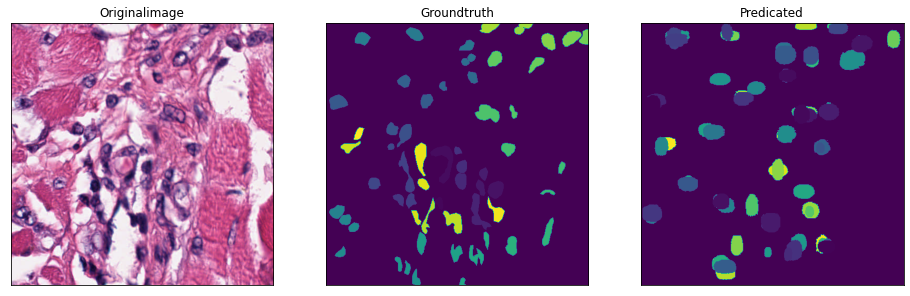

In [15]:
n = 5
ids=[0,10,15,30,26]
for i in ids:
  # pick one image from the test set
  img, apred = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  orig=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  t=apred['masks'].permute(1,2,0)
  g=np.argmax(t,axis=2) 
  k=(prediction[0]['masks']>0.5).mul(1).squeeze().detach().cpu().numpy()
  k=np.argmax(k,axis=0) 
  visualize(OriginalImage = orig, GroundTruth=g,Predicated=k)


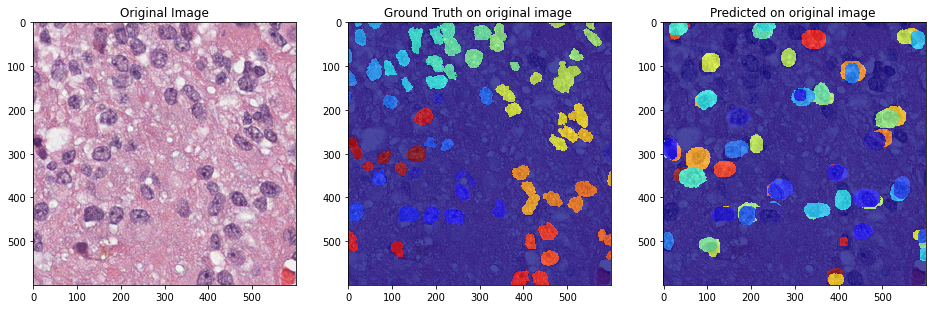

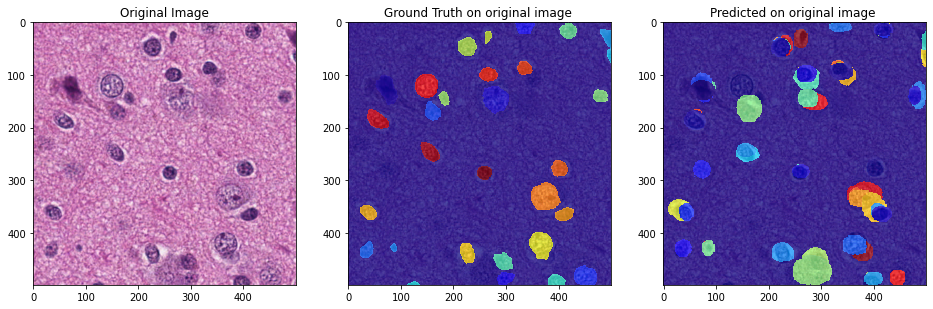

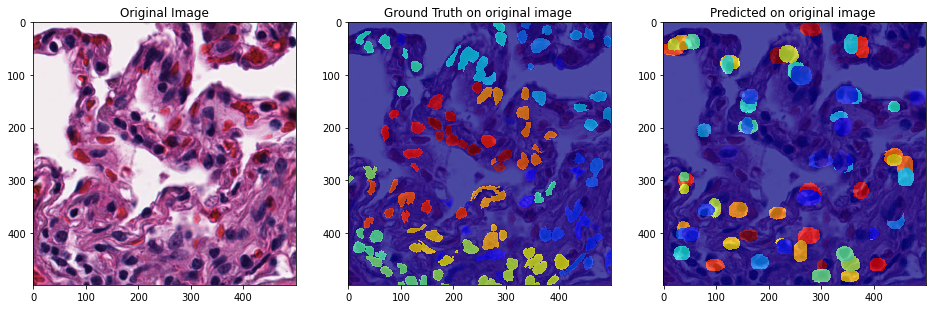

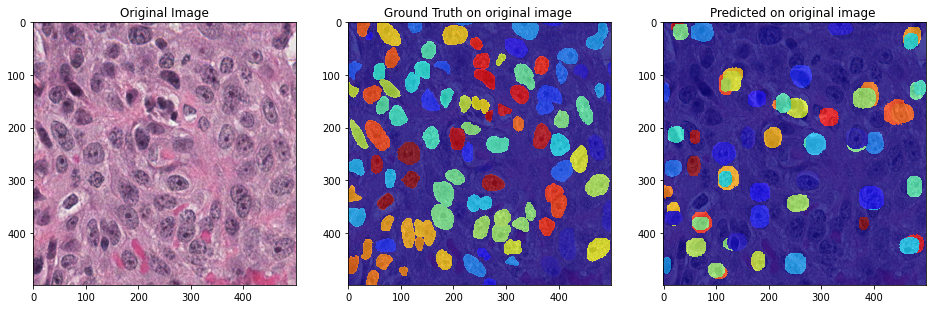

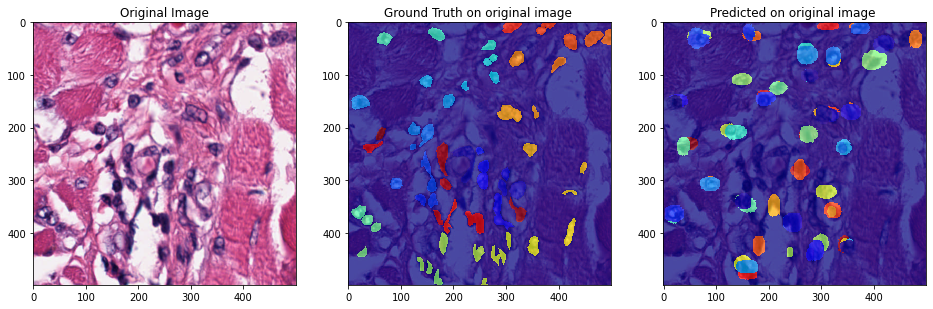

In [16]:
n = 5
ids=[0,10,15,30,26]
for i in ids:
  # pick one image from the test set
  img, apred = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  orig=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  t=apred['masks'].permute(1,2,0)
  g=np.argmax(t,axis=2) 
  k=(prediction[0]['masks']>0.5).mul(1).squeeze().detach().cpu().numpy()
  k=np.argmax(k,axis=0) 
  plt.figure(figsize=(16, 5))
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(orig)
  plt.subplot(1, 3, 2)
  plt.imshow(orig, interpolation='none')
  plt.imshow(g, 'jet', interpolation='none', alpha=0.7)
  plt.title("Ground Truth on original image ")
  plt.subplot(1, 3, 3)
  plt.imshow(orig, interpolation='none')
  plt.imshow(k, 'jet', interpolation='none', alpha=0.7)
  plt.title("Predicted on original image ")
  
  plt.show()
